In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

%matplotlib inline
%load_ext autoreload
%autoreload 2

# For Sklearn warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


In [2]:
cd ../..

/Users/logang/Dropbox/GrosenickLab/Code/PCMF


In [3]:
from pcmf_dataloaders import load_COVID, load_penguins, load_NCI_MV, load_SRBCT_MV, load_mouseorgans_MV, load_gbmBreastLung_MV


In [4]:
def generate_PMD_data(m=100, n_X=10, sigma=1, density=0.5, mean=0, seed=1):
    "Generates data matrix for PCMF."
    np.random.seed(seed)
    u_star = np.random.randn(m) / 3.0
    v_star = np.random.randn(n_X) / 3.0
    X = np.random.normal(mean,sigma,size=((m,n_X))) / 3.0
    X_idxs = np.random.choice(range(n_X), int(density*n_X), replace=False)
    for idx in X_idxs:
        X[:,idx] += v_star[idx]*u_star

    return X, u_star, v_star

def generate_cluster_PMD_data(m=[50,50,20], n_X=20, sigma=0.075, density=1.0, n_clusters=3, 
                              means=[-0.35,0.2,0.35], gen_seeds=True, seeds=[], verbose=False):
    '''
    Generates multiple cluster data matrix for PCMF.
    '''
    X_out = []
    u_stars = []
    v_stars = []

    for nc in range(n_clusters):
        if gen_seeds is True:
            seed = np.random.randint(99999)
            seeds.append(seed)
            # print('generating seeds')                                                                                  
        # else:                                                                                                          
            # print(seeds)                                                                                               
            # print('NOT generating seeds')                                                                              

        if verbose == True:
            print(seeds)

        X, u_star, v_star = generate_PMD_data(m[nc], n_X, sigma, density, mean=means[nc], seed=seeds[nc])
        X_out.append(X)
        u_stars.append(u_star)
        v_stars.append(v_star)
    return X_out, u_stars, v_stars, seeds



In [5]:
from matplotlib import cm

def path_plot(coefficient_arr, penalty_list, plot_range=[0,-1], cut_vars=False, 
              first_vars_only=False, var_sel=1, true_clusters=None,figsize=(20,10), xticks=None):
    # Crop x axis (e.g, to remove 'burn-in' period at beginning)                                                         
    coefficient_arr = coefficient_arr[plot_range[0]:plot_range[1],:,:]
    penalty_list = penalty_list[plot_range[0]:plot_range[1]]
    if cut_vars is True:
        coefficient_arr = coefficient_arr[:,:,[1,2,coefficient_arr.shape[2]-1]]

    if first_vars_only is True:
        coefficient_arr = coefficient_arr[:,:,[var_sel]]

    # Colormap                                                                                                           
    cmap = matplotlib.cm.get_cmap('tab20b')

    #cm.get_cmap('viridis', coefficient_arr.shape[2])
    if true_clusters is not None:
        colors = cmap(np.linspace(0.0,1.0,np.max(true_clusters)+1))
    else:
        colors = cmap(np.linspace(0.0,1.0,6))
    
    # Define x-axis range                                                                                                
    penalty_range = range(len(penalty_list))

    # Make figure
    fig, ax = plt.subplots(1,1, figsize=figsize)

    for i in range(coefficient_arr.shape[2]):
        x = np.round(np.array(penalty_list),8)[penalty_range]
        y = coefficient_arr[penalty_range,:,i]
        if true_clusters is not None:
            # Make different line types for different clusters
            linetypes = ['dotted']*len(true_clusters)
            color_list = [colors[i]]*len(true_clusters)
            for j, tc in enumerate(true_clusters):
                if tc == 1:
                    linetypes[j] = 'solid'
                    color_list[j] = colors[tc]
                elif tc == 2:
                    linetypes[j] = 'dashed'
                    color_list[j] = colors[tc]
                elif tc == 3:
                    linetypes[j] = 'dashdot'
                    color_list[j] = colors[tc]
                else:
                    linetypes[j] = 'dotted'
                    color_list[j] = colors[tc]

            # Plot the lines and set linestyle
            ax.plot(np.arange(x.shape[0]), y, color=colors[i], alpha=0.5)
            for l, line in enumerate(ax.get_lines()):
                line.set_linestyle(linetypes[l])
                line.set_color(color_list[l])
        else:
            ax.plot(np.arange(x.shape[0]), y, color=colors[i], alpha=0.5)
        # Set plot ticks and labels
        ax.set_xticks(range(x.shape[0]), minor=False);
        plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        x = [str(xx)[0:9] for xx in x]
        ax.set_xticklabels(x) #,fontsize=24)
        evens = np.arange(0,len(ax.xaxis.get_ticklabels())+1,2)
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False) 
    ax.tick_params(axis='y') #, labelsize=24)
    plt.xlabel(r'$\lambda$',fontsize=16)
    plt.ylabel('Coefficients',fontsize=16)
    sns.despine()
    
    
def path_plot_video(coefficient_arr, penalty_list, penalty_idx, fig, ax, plot_range=[0,-1], cut_vars=False, 
              first_vars_only=False, var_sel=1, true_clusters=None,figsize=(20,10), xticks=None):
    # Crop x axis (e.g, to remove 'burn-in' period at beginning)                                                         
    coefficient_arr = coefficient_arr[plot_range[0]:plot_range[1],:,:]
    penalty_list = penalty_list[plot_range[0]:plot_range[1]]
    if cut_vars is True:
        coefficient_arr = coefficient_arr[:,:,[1,2,coefficient_arr.shape[2]-1]]

    if first_vars_only is True:
        coefficient_arr = coefficient_arr[:,:,[var_sel]]

    # Colormap                                                                                                           
    cmap = matplotlib.cm.get_cmap('tab20b')

    #cm.get_cmap('viridis', coefficient_arr.shape[2])
    colors = cmap(np.linspace(0.0,1.0,3))
    
    # Define x-axis range                                                                                                
    penalty_range = range(len(penalty_list))

    # Make figure
#     fig, ax = plt.subplots(1,1, figsize=figsize)

    for i in range(coefficient_arr.shape[2]):
        x = np.round(np.array(penalty_list),8)[penalty_range]
        y = coefficient_arr[penalty_range,:,i]
        if true_clusters is not None:
            # Make different line types for different clusters
            linetypes = ['dotted']*len(true_clusters)
            color_list = [colors[i]]*len(true_clusters)
            for j, tc in enumerate(true_clusters):
                if tc == 1:
                    linetypes[j] = 'solid'
                    color_list[j] = colors[tc]
                elif tc == 2:
                    linetypes[j] = 'dashed'
                    color_list[j] = colors[tc]
                elif tc == 3:
                    linetypes[j] = 'dashdot'
                    color_list[j] = colors[tc]
                else:
                    linetypes[j] = 'dotted'
                    color_list[j] = colors[tc]

            # Plot the lines and set linestyle
            ax.plot(np.arange(x.shape[0]), y, color=colors[i], alpha=0.5)
            for l, line in enumerate(ax.get_lines()):
                line.set_linestyle(linetypes[l])
                line.set_color(color_list[l])
        else:
            ax.plot(np.arange(x.shape[0]), y, color=colors[i], alpha=0.5)
        # Set plot ticks and labels
        ax.set_xticks(range(x.shape[0]), minor=False);
        plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        x = [str(xx)[0:9] for xx in x]
        ax.set_xticklabels(x) #,fontsize=24)
        evens = np.arange(0,len(ax.xaxis.get_ticklabels())+1,2)
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False) 
    ax.tick_params(axis='y') #, labelsize=24)
    plt.xlabel(r'$\lambda$',fontsize=16)
    plt.ylabel('Coefficients',fontsize=16)
    
    plt.plot([penalty_idx,penalty_idx],[-0.1,0.5],color='black')
    plt.locator_params(axis='x',nbins=25)
        
    sns.despine()

In [6]:
from scipy.sparse import csr_matrix
from itertools import combinations
import networkx as nx
from scipy.stats import norm
from sklearn.mixture import GaussianMixture

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

def sparse_D(n,p):
    '''                                                                                                                  
    Construct a sparse matrix, that when applied to a vector containing concatenated vectors                             
    of coefficients b = [b_1 b_2 ... b_n] where each b_i is p=num_var long and there are                                 
    n = num_vec of them. Differences are taken between conformal elements (e.g. b_11 and b_21)                           
    across all unique pairwise combinations of vectors.                                                                  
    '''
    comb_list = list(combinations(range(n),2))
    combs_arr = np.array(comb_list)
    num_combs = combs_arr.shape[0]
    data = np.ones_like(combs_arr)
    data[:,1] *= -1
    row = np.repeat(range(num_combs),2)
    col = combs_arr.flatten()
    return csr_matrix((data.flatten(), (row, col)), shape=(num_combs, n)), comb_list



In [7]:
### Cluster matching ###
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans

from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import linprog
from scipy.optimize import linear_sum_assignment as linear_assignment

def cluster_matching(pred, true):
    'New function for hungrarian matching clusters'
    from sklearn.metrics import confusion_matrix, accuracy_score
    from scipy.optimize import linprog
    from scipy.optimize import linear_sum_assignment as linear_assignment
    def _make_cost_m(cm):
        s = np.max(cm)
        return (- cm + s)
    conf_mat = confusion_matrix(pred,true)
    indexes = linear_assignment(_make_cost_m(conf_mat))

    pred_new = np.copy(pred)
    for clusterN in range(len(np.unique(pred))):
        pred_new[pred==clusterN]= indexes[1][clusterN]

    return pred_new


## Load data

In [58]:
import pandas as pd
import numpy as np
import time
from pcmf_dataloaders import load_NCI, load_SRBCT, load_mouseorgans, load_gbmBreastLung
from pcmf_experiments_2023 import fit_pca_carp
from sklearn.preprocessing import StandardScaler

data_path = '/Users/logang/Dropbox/GrosenickLab/Code/clusterCCA/data/datasets/'
dataset = 'MouseOrgans'

if dataset == 'NCI':
    Xall, true_clusters = load_NCI(path=data_path+'nci.npz')
elif dataset == 'SRBCT':
    Xall, true_clusters = load_SRBCT(path=data_path+'SRBCT.npz')
elif dataset == 'MouseOrgans':
    Xall, true_clusters = load_mouseorgans(path=data_path)
elif dataset == 'gbmBreastLung':
    Xall, true_clusters = load_gbmBreastLung(path=data_path+'GbmBreastLungCancer.npz')

scaler = StandardScaler()
X_c = scaler.fit_transform(Xall)

# Remove singleton clusters
vals, counts = np.unique(true_clusters, return_counts=True)
singleton_vals = vals[np.where(counts==1)[0]]
singleton_idxs = []
for i, tc in enumerate(true_clusters):
    if tc in singleton_vals:
        singleton_idxs.append(i)
keep_idx = [i for i in range(X_c.shape[0]) if i not in singleton_idxs]
X_c = X_c[keep_idx,:]
true_clusters = true_clusters[keep_idx]

num_clusters = len(np.unique(true_clusters))
print('Number of clusters:', num_clusters)
num_components = num_clusters + 1

Mouse Organs samples (125, 16944)
Number of clusters: 7


In [9]:
X_c.shape

(59, 6831)

In [10]:
colors = ['darkblue','darkorange','red','green','purple']
plot_idxs = [0,1]
scatter_cmap = 'tab20b'
scatter_alpha = 0.3

(-0.5, 58.5, 58.5, -0.5)

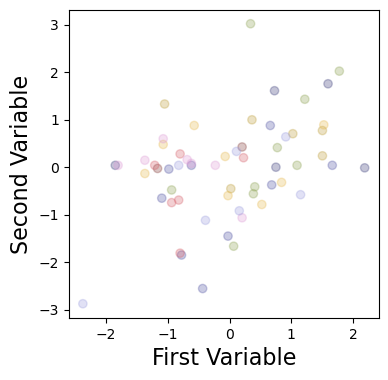

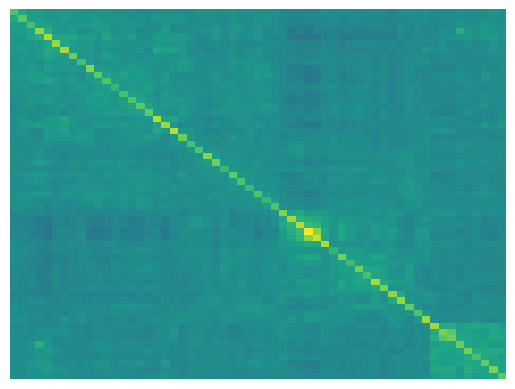

In [11]:
# Plot clusters
plt.figure(figsize=(4,4))
plt.scatter(X_c[:,plot_idxs[0]],X_c[:,plot_idxs[1]], c=true_clusters, cmap=scatter_cmap, alpha=scatter_alpha)
# plt.xlim(-0.5, 0.65)
# plt.ylim(-0.2, 0.65)
plt.xlabel('First Variable',fontsize=16)
plt.ylabel('Second Variable',fontsize=16)

# Plot PCA approximation with num_components components
#X_pcas = list()
#for ncl in range(num_clusters):
#    idx = np.where(true_clusters==ncl)[0]
#    u,d,vh = np.linalg.svd(X_c[idx,:], full_matrices=False)
#    X_pca = np.dot(np.dot(u[:,0:num_components],np.diag(d[0:num_components])),vh[0:num_components,:])
   # plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors[ncl])

# Plot Covariance
plt.figure()
C = np.dot(X_c,X_c.T)
maxval = np.max(np.abs(C))
plt.imshow(C,aspect='auto',interpolation='nearest',cmap='viridis',vmin=-1*maxval, vmax=maxval)  
plt.axis('off')


### Run PCMF Full

In [12]:
penalty_list = np.concatenate((np.repeat(np.inf,10),np.exp(np.linspace(-10,30,250))[::-1]),axis=0)
# 5

In [13]:
from pcmf import pcmf_full, pcmf_approx_uV, plot_ordercolor, plot_cluster_assignments

gc = 2.0 
nn = np.min(counts)
print("Number of neighbors:", nn)

# Fit full model
A_list, U_list, s_list, V_list = pcmf_full(X_c, penalty_list, problem_rank=num_components, rho=1.2, numba=True, gauss_coef=gc, weights='Gaussian', admm_iters = 10, neighbors=nn)



Number of neighbors: 1
weights: Gaussian neighbors: 1 gauss_coef: 2.0 rho: 1.2
[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 1.06865e+13...[ 12 ] 9.10056e+12...[ 13 ] 7.75001e+12...[ 14 ] 6.59988e+12...[ 15 ] 5.62043e+12...[ 16 ] 4.78634e+12...[ 17 ] 4.07603e+12...[ 18 ] 3.47113e+12...[ 19 ] 2.95600e+12...[ 20 ] 2.51732e+12...[ 21 ] 2.14374e+12...[ 22 ] 1.82560e+12...[ 23 ] 1.55468e+12...[ 24 ] 1.32396e+12...[ 25 ] 1.12748e+12...[ 26 ] 9.60156e+11...[ 27 ] 8.17665e+11...[ 28 ] 6.96321e+11...[ 29 ] 5.92984e+11...[ 30 ] 5.04983e+11...[ 31 ] 4.30042e+11...[ 32 ] 3.66222e+11...[ 33 ] 3.11873e+11...[ 34 ] 2.65590e+11...[ 35 ] 2.26176e+11...[ 36 ] 1.92610e+11...[ 37 ] 1.64026e+11...[ 38 ] 1.39684e+11...[ 39 ] 1.18955e+11...[ 40 ] 1.01301e+11...[ 41 ] 8.62679e+10...[ 42 ] 7.34654e+10...[ 43 ] 6.25629e+10...[ 44 ] 5.32783e+10...[ 45 ] 4.53716e+10...[ 46 ] 3.86383e+10...[ 47 ] 3.29042e+10...[ 48 ] 2.80211e+10...[ 

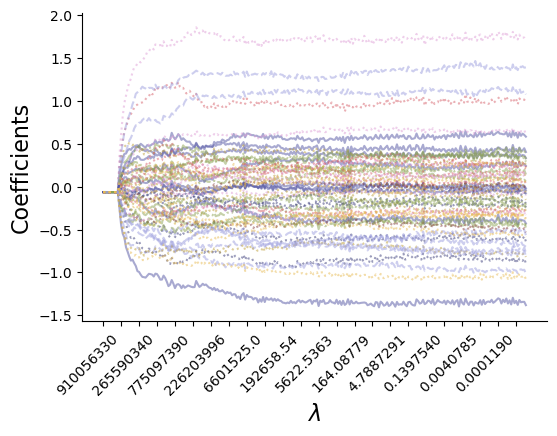

In [14]:
# Plot paths
import matplotlib
import seaborn as sns
path_plot(np.asarray(A_list)[:,:,21:22], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters,figsize=(6,4))
          #xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 

plt.locator_params(axis='x',nbins=25)

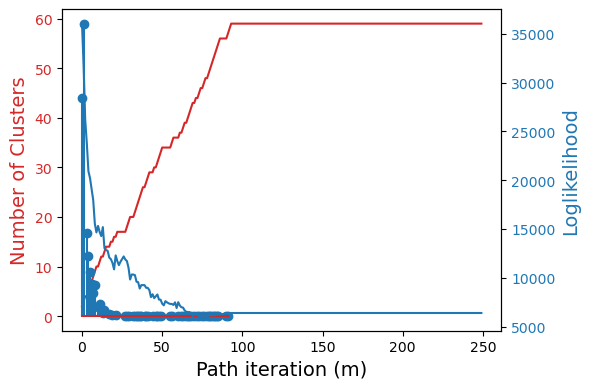

In [15]:
from pcmf import cluster_path

n_clusts, ics, centroids = cluster_path(X_c, A_list, penalty_list, gauss_coef=gc, neighbors=nn, selection='lik', method='kmeans')

t = range(len(ics))
data1 = n_clusts
data2 = ics

clust_change_idx = np.where(np.diff(n_clusts)==1)[0] 
N = X_c.shape[0]
Ts = []
for i in range(len(clust_change_idx)-1):
    notinf_idx = np.where(np.asarray(penalty_list)<np.inf)[0]
    penalty_list_noinf = penalty_list[notinf_idx]
    lambda_t = penalty_list_noinf[clust_change_idx[i]]
    lambda_t_next = penalty_list_noinf[clust_change_idx[i+1]]
    Ts.append(N*lambda_t*(lambda_t - lambda_t_next))

fig, ax1 = plt.subplots(figsize=(6,4))

color = 'tab:red'
ax1.set_xlabel('Path iteration (m)',fontsize=14)
ax1.set_ylabel('Number of Clusters', color=color,fontsize=14)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.stem(clust_change_idx[:-1], np.max(data1)*(Ts/np.max(Ts))) #, use_line_collection=True)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Loglikelihood', color=color,fontsize=14)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [16]:
print(list(zip(np.array(n_clusts)[clust_change_idx[:-1]+1], np.max(data1)*(Ts/np.max(Ts)))))

[(3, 43.93777362585392), (4, 59.0), (5, 16.758724284498236), (6, 12.153702245290269), (7, 8.814064588663296), (8, 6.392104480199924), (9, 4.6356592097524185), (10, 6.224800912863211), (11, 1.768130885162161), (12, 2.374260542031276), (13, 0.6743996237875511), (14, 1.2602822823483415), (15, 0.3454094323739269), (16, 0.18166424811305618), (17, 0.21508503596287498), (18, 0.007506962182663137), (19, 0.005444172335906044), (20, 0.010173780789585344), (21, 0.0015059217634940522), (22, 0.0010921192095234944), (23, 0.000792022797414765), (24, 0.0005743879479039416), (25, 0.0004165555786704573), (26, 0.0005593542210590175), (27, 0.0001588824265779382), (28, 0.00011522414665080163), (29, 0.00021532477984962132), (30, 5.9014723150204467e-05), (31, 1.6762906338987662e-05), (32, 1.2156735139929213e-05), (33, 8.816264093694674e-06), (34, 2.6650417306702697e-05), (35, 9.30160826753837e-07), (36, 2.1548428164596378e-06), (37, 3.454956275426506e-07), (38, 9.813671124554044e-08), (39, 1.3177877451851445

Using correlation statistic for selection...
[4]


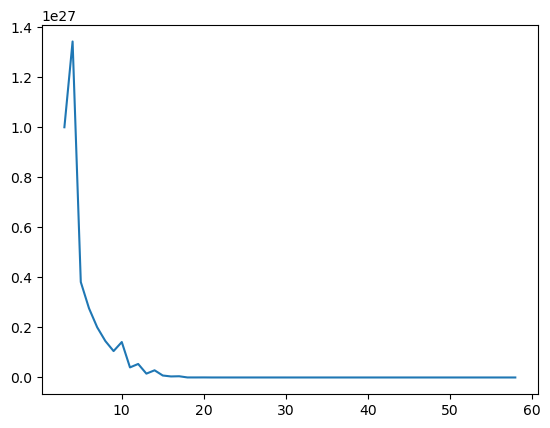

In [17]:
N = X_c.shape[0]
    
def select_nclust(n_clust_list, penalty_list, N, method='cor_stat'):
    notinf_idx = np.where(np.asarray(penalty_list)<np.inf)[0]
    penalty_list = penalty_list[notinf_idx]
    clust_change_idx = np.where(np.diff(n_clust_list)==1)[0]+1
    Ts = []
    clust_nums = np.array(n_clusts)[clust_change_idx[:-1]+1]
    for i in range(len(clust_change_idx)-1):
        lambda_t = penalty_list_noinf[clust_change_idx[i]]
        lambda_t_next = penalty_list_noinf[clust_change_idx[i+1]]
        #print(N*lambda_t*(lambda_t - lambda_t_next), clust_nums[i])
        Ts.append(N*lambda_t*(lambda_t - lambda_t_next))
    if len(Ts) > 0 and method == 'cor_stat':
        print("Using correlation statistic for selection...")
        return clust_nums[np.where(np.array(Ts)==np.max(np.nan_to_num(np.array(Ts),posinf=0.0)))[0]]
    else:
        print("Using modal path value for selection...")
        from scipy.stats import mode
        return mode(np.array(n_clust_list)[np.where(np.array(n_clust_list)>1)[0]])[0]

plt.plot(np.array(range(len(Ts)))+n_clusts[0]+1, np.array(Ts))
selected = select_nclust(n_clusts, penalty_list, X_c.shape[0])
print(selected)


In [18]:
selected = select_nclust(n_clusts, penalty_list, X_c.shape[0], method='mode'); n_clusts[0]
print(selected)


Using modal path value for selection...
59


In [19]:
def fit_elasticnetsubspace(X, n_clusters):
    '''Elastic net clustering'''
    from cluster.selfrepresentation import ElasticNetSubspaceClustering
    data_in = X
    essc = ElasticNetSubspaceClustering(n_clusters=n_clusters, algorithm='spams', gamma=5, active_support=False, tau=0.1).fit(data_in)
    labels = essc.labels_
    return labels
    
def fit_ward(X, n_clusters):
    '''Ward clustering'''
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.neighbors import kneighbors_graph
    data_in = X
    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(data_in, n_neighbors=10, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', connectivity=connectivity).fit(data_in)
    labels = clustering.labels_    
    return labels #, ari, nmi, acc

def fit_spectral(X, n_clusters):
    '''Spectral clustering'''
    from sklearn.cluster import SpectralClustering
    data_in = X
    spectral_clustering = SpectralClustering(n_clusters=n_clusters, random_state=20, affinity="nearest_neighbors").fit(data_in)
    labels = spectral_clustering.labels_
    return labels

def fit_dpgmm(X, n_clusters):
    '''DPGMM clustering'''
    from sklearn import mixture
    data_in = X
    dpgmm = mixture.BayesianGaussianMixture(n_components=n_clusters, covariance_type='full', weight_concentration_prior_type='dirichlet_process',max_iter=1000)
    dpgmm_mod = dpgmm.fit(data_in)
    labels = dpgmm.predict(data_in)

    return labels
    

In [20]:
cd /Users/logang/Dropbox/GrosenickLab/Code/PCMF

/Users/logang/Dropbox/GrosenickLab/Code/PCMF


In [21]:
from pcmf_deepcomparisons import fit_dec 


In [22]:
cd /Users/logang/Dropbox/GrosenickLab/Code/clusterCCA/utils/subspace-clustering-master


/Users/logang/Dropbox/GrosenickLab/Code/clusterCCA/utils/subspace-clustering-master


In [59]:
import progressbar
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score, mean_squared_error

# Initialize containers
pcmf_num_clusts = []
pca_kmeans_si = []; pca_kmeans_ch = []; pca_kmeans_db = []
pca_spectral_si = []; pca_spectral_ch = []; pca_spectral_db = []
ward_si = []; ward_ch = []; ward_db = []
spectral_si = []; spectral_ch = []; spectral_db = []
elasticsubspace_si = []; elasticsubspace_ch = []; elasticsubspace_db = []
dec_si = []; dec_ch = []; dec_db = []

datasets = ['NCI', 'SRBCT', 'MouseOrgans', 'gbmBreastLung']

dataset = 'MouseOrgans'
nn = 15
for dset in ['SRBCT']:
    # Load data
    if dataset == 'NCI':
        Xall, true_clusters = load_NCI(path=data_path+'nci.npz')
    elif dataset == 'SRBCT':
        Xall, true_clusters = load_SRBCT(path=data_path+'SRBCT.npz')
    elif dataset == 'MouseOrgans':
        Xall, true_clusters = load_mouseorgans(path=data_path)
    elif dataset == 'gbmBreastLung':
        Xall, true_clusters = load_gbmBreastLung(path=data_path+'GbmBreastLungCancer.npz')
    
    scaler = StandardScaler()
    X_c = np.nan_to_num(scaler.fit_transform(Xall))
    
    num_clusters = len(np.unique(true_clusters))
    print('Number of clusters:', num_clusters)
    num_components = num_clusters + 1

    # # Fit full model
    # A_list, U_list, s_list, V_list = pcmf_full(X_c, penalty_list, problem_rank=num_components, rho=1.2, numba=True, gauss_coef=gc, weights='Gaussian', admm_iters = 10, neighbors=nn)
    # n_clusts, ics, centroids = cluster_path(X_c, A_list, penalty_list, gauss_coef=gc, neighbors=nn, selection='lik')
    # pcmf_num_clusts.append(select_nclust(n_clusts, penalty_list, X_c.shape[0]))
    # del A_list, U_list, s_list, V_list

    #  # Fit partial u,V model
    # V_list_approx_uV, u_list_approx_uV, s_list_approx_uV =  pcmf_approx_uV(X_c, penalty_list, rho=1.2, numba=True, gauss_coef=gc, weights='Gaussian', admm_iters = 10, neighbors=nn)
    # Apals_list = []
    # spals_list = []
    # for p in range(len(penalty_list)):
    #     spals_list.append(u_list_approx_uV[p].T@X_c@V_list_approx_uV[p].T)
    #     x_pcmf = []
    #     for i in range(X_c.shape[0]):
    #         x_pcmf.append(np.dot(np.dot(u_list_approx_uV[p][i,:],spals_list[p][:,i]),V_list_approx_uV[p][i,:]))
    #     Apals_list.append(x_pcmf)
    # n_clusts, ics, centroids = cluster_path(X_c, np.asarray(Apals_list), penalty_list, gauss_coef=gc, neighbors=nn, selection='lik', method='spectral')
    # pcmf_num_clusts.append(select_nclust(n_clusts, penalty_list, X_c.shape[0]))
    # del Apals_list, spals_list

    # # Fit Ward
    # si = []; ch = []; db = []
    # for nc in range(2,12):
    #     labels = fit_ward(X_c, nc)
    #     si.append(silhouette_score(X_c, labels))
    #     ch.append(calinski_harabasz_score(X_c, labels))
    #     db.append(davies_bouldin_score(X_c, labels))
    # ward_si.append(np.where(si==np.max(si))[0] + 2)
    # ward_ch.append(np.where(ch==np.max(ch))[0] + 2)
    # ward_db.append(np.where(db==np.max(db))[0] + 2)

    # # Fit Spectral
    # si = []; ch = []; db = []
    # for nc in range(2,12):
    #     labels = fit_spectral(X_c, nc)
    #     si.append(silhouette_score(X_c, labels))
    #     ch.append(calinski_harabasz_score(X_c, labels))
    #     db.append(davies_bouldin_score(X_c, labels))
    # spectral_si.append(np.where(si==np.max(si))[0] + 2)
    # spectral_ch.append(np.where(ch==np.max(ch))[0] + 2)
    # spectral_db.append(np.where(db==np.max(db))[0] + 2)
    
    # # Fit PCA-kmeans
    # u,d,vh = np.linalg.svd(X_c, full_matrices=False)
    # si = []; ch = []; db = []
    # for nc in range(2,12):
    #     kmeans = KMeans(n_clusters=nc, random_state=0).fit(u[:,0:num_components])
    #     si.append(silhouette_score(X_c, kmeans.labels_))
    #     ch.append(calinski_harabasz_score(X_c, kmeans.labels_))
    #     db.append(davies_bouldin_score(X_c, kmeans.labels_))
    # pca_kmeans_si.append(np.where(si==np.max(si))[0] + 2)
    # pca_kmeans_ch.append(np.where(ch==np.max(ch))[0] + 2)
    # pca_kmeans_db.append(np.where(db==np.max(db))[0] + 2)

    # # Fit PCA-spectral
    # si = []; ch = []; db = []
    # for nc in range(2,12):
    #     spectral_clustering = SpectralClustering(n_clusters=nc, random_state=i, affinity="nearest_neighbors", assign_labels="cluster_qr").fit(u[:,0:num_components])
    #     si.append(silhouette_score(X_c, spectral_clustering.labels_))
    #     ch.append(calinski_harabasz_score(X_c, spectral_clustering.labels_))
    #     db.append(davies_bouldin_score(X_c, spectral_clustering.labels_))
    # pca_spectral_si.append(np.where(si==np.max(si))[0] + 2)
    # pca_spectral_ch.append(np.where(ch==np.max(ch))[0] + 2)
    # pca_spectral_db.append(np.where(db==np.max(db))[0] + 2)
    
    # # Fit Elastic Subspace
    # si = []; ch = []; db = []
    # for nc in range(2,12):
    #     labels = fit_elasticnetsubspace(X_c, nc)
    #     si.append(silhouette_score(X_c, labels))
    #     ch.append(calinski_harabasz_score(X_c, labels))
    #     db.append(davies_bouldin_score(X_c, labels))
    # elasticsubspace_si.append(np.where(si==np.max(si))[0] + 2)
    # elasticsubspace_ch.append(np.where(ch==np.max(ch))[0] + 2)
    # elasticsubspace_db.append(np.where(db==np.max(db))[0] + 2)

    # Fit DEC
    si = []; ch = []; db = []
    for nc in range(2,12):
        labels, _, _ = fit_dec(X_c, true_clusters, batch_size_options=[40], finetune_iters_options=[10], layerwise_pretrain_iters_options=[10], cluster_iter_max_options=[30])
        labels = labels[0]
        si.append(silhouette_score(X_c, labels))
        ch.append(calinski_harabasz_score(X_c, labels))
        db.append(davies_bouldin_score(X_c, labels))
    dec_si.append(np.where(si==np.max(si))[0] + 2)
    dec_ch.append(np.where(ch==np.max(ch))[0] + 2)
    dec_db.append(np.where(db==np.max(db))[0] + 2)


Mouse Organs samples (125, 16944)
Number of clusters: 7
(125, 16944)
layerwise pretrain
Epoch 1/333
4/4 [==============================] - 0s 23ms/step - loss: 0.9107 - lr: 0.1000
Epoch 2/333
4/4 [==============================] - 0s 25ms/step - loss: 0.9051 - lr: 0.1000
Epoch 3/333
4/4 [==============================] - 0s 24ms/step - loss: 0.8997 - lr: 0.1000
Epoch 4/333
4/4 [==============================] - 0s 31ms/step - loss: 0.8926 - lr: 0.1000
Epoch 5/333
4/4 [==============================] - 0s 25ms/step - loss: 0.8873 - lr: 0.1000
Epoch 6/333
4/4 [==============================] - 0s 24ms/step - loss: 0.8819 - lr: 0.1000
Epoch 7/333
4/4 [==============================] - 0s 24ms/step - loss: 0.8773 - lr: 0.1000
Epoch 8/333
4/4 [==============================] - 0s 23ms/step - loss: 0.8739 - lr: 0.1000
Epoch 9/333
4/4 [==============================] - 0s 24ms/step - loss: 0.8708 - lr: 0.1000
Epoch 10/333
4/4 [==============================] - 0s 23ms/step - loss: 0.8671 - lr

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [53]:
pcmf_num_clusts

[]

In [54]:
# Correct for occasional ragged array results from DEC output
for i in range(len(dec_si)):
    if dec_si[i].shape==():
        dec_si[i] = np.array([dec_si[i]])
    if dec_si[i].shape[0]>1:
        dec_si[i] = np.array([dec_si[i][0]])

    if dec_ch[i].shape==():
        dec_ch[i] = np.array([dec_ch[i]])
    if dec_ch[i].shape[0]>1:
        dec_ch[i] = np.array([dec_ch[i][0]])

    if dec_db[i].shape==():
        dec_db[i] = np.array([dec_db[i]])
    if dec_db[i].shape[0]>1:
        dec_db[i] = np.array([dec_db[i][0]])

np.mean(dec_ch)

7.0

In [55]:
dec_db

[array([6])]

In [56]:
#print("PCMF:", np.mean(pcmf_num_clusts), np.std(pcmf_num_clusts))
print("PCA+Kmeans Silhouette:", np.mean(pca_kmeans_si), np.std(pca_kmeans_si))
print("PCA+Kmeans Calinski-Harabasz:", np.mean(pca_kmeans_ch), np.std(pca_kmeans_ch))
print("PCA+Kmeans Davies-Bouldin:", np.mean(pca_kmeans_db), np.std(pca_kmeans_db))
print("PCA+SC Silhouette:", np.mean(pca_spectral_si), np.std(pca_spectral_si))
print("PCA+SC Calinski-Harabasz:", np.mean(pca_spectral_ch), np.std(pca_spectral_ch))
print("PCA+SC Davies-Bouldin:", np.mean(pca_spectral_db), np.std(pca_spectral_db))
print("SC Silhouette:", np.mean(spectral_si), np.std(spectral_si))
print("SC Calinski-Harabasz:", np.mean(spectral_ch), np.std(spectral_ch))
print("SC Davies-Bouldin:", np.mean(spectral_db), np.std(spectral_db))
print("Elastic Subspace Silhouette:", np.mean(elasticsubspace_si), np.std(elasticsubspace_si))
print("Elastic Subspace Calinski-Harabasz:",  np.mean(elasticsubspace_ch), np.std(elasticsubspace_ch))
print("Elastic Subspace Davies-Bouldin:",  np.mean(elasticsubspace_db), np.std(elasticsubspace_db))
print("DEC Silhouette:", np.mean(dec_si), np.std(dec_si))
print("DEC Calinski-Harabasz:",  np.mean(dec_ch), np.std(dec_ch))
print("DEC Davies-Bouldin:",  np.mean(dec_db), np.std(dec_db))

PCA+Kmeans Silhouette: nan nan
PCA+Kmeans Calinski-Harabasz: nan nan
PCA+Kmeans Davies-Bouldin: nan nan
PCA+SC Silhouette: nan nan
PCA+SC Calinski-Harabasz: nan nan
PCA+SC Davies-Bouldin: nan nan
SC Silhouette: nan nan
SC Calinski-Harabasz: nan nan
SC Davies-Bouldin: nan nan
Elastic Subspace Silhouette: nan nan
Elastic Subspace Calinski-Harabasz: nan nan
Elastic Subspace Davies-Bouldin: nan nan
DEC Silhouette: 7.0 0.0
DEC Calinski-Harabasz: 7.0 0.0
DEC Davies-Bouldin: 6.0 0.0


### Run PCMF PALS

In [24]:
pwd

'/Users/logang/Dropbox/GrosenickLab/Code/clusterCCA/utils/subspace-clustering-master'

In [25]:
import sys
sys.path.append("./scikit-sparse/")

In [26]:
import sksparse as sps

In [16]:
from pcmf import pcmf_full, pcmf_approx_uV, plot_ordercolor, plot_cluster_assignments

gc = 2.0 

# Fit partial u,V model
V_list_approx_uV, u_list_approx_uV, s_list_approx_uV =  pcmf_approx_uV(X_c, penalty_list, rho=1.5, numba=True, gauss_coef=gc, weights='Gaussian', admm_iters = 5, neighbors=15)


ModuleNotFoundError: No module named 'sksparse.cholmod'

In [61]:
networkx.__version__, scipy.__version__


('2.6.3', '1.9.3')

In [36]:
cluster_pcmfs_pals

[]

In [60]:
%load_ext autoreload

%autoreload 2

import importlib
import scipy
#import networkx #import the module here, so that it can be reloaded.
#importlib.reload(networkx)
importlib.reload(scipy)

Apals_list = []
spals_list = []
for p in range(len(penalty_list)):
    spals_list.append(u_list_approx_uV[p].T@X_c@V_list_approx_uV[p].T)
    x_pcmf = []
    for i in range(X_c.shape[0]):
        x_pcmf.append(np.dot(np.dot(u_list_approx_uV[p][i,:],spals_list[p][:,i]),V_list_approx_uV[p][i,:]))
    Apals_list.append(x_pcmf)

    
cluster_pcmfs_pals = []
for i in range(len(penalty_list)):
    cluster_pcmf_pals = diff_graph_cluster(np.array(Apals_list[i]), D, comb_list, num_clusters).astype(int)
    cluster_pcmfs_pals.append(cluster_pcmf_pals)
    

# cluster_pcmfs_pals_new = []
# for idx in range(0,len(cluster_pcmfs_pals)):
#     cluster_pcmfs_pals_new.append( cluster_matching(cluster_pcmfs_pals[idx], true_clusters ) )




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/logang/opt/anaconda3/envs/tmspred/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/q8/v05ct80136s_vt_x7bq2dq780000gn/T/ipykernel_24320/1954471005.py", line 23, in <cell line: 22>
    cluster_pcmf_pals = diff_graph_cluster(np.array(Apals_list[i]), D, comb_list, num_clusters).astype(int)
  File "/var/folders/q8/v05ct80136s_vt_x7bq2dq780000gn/T/ipykernel_24320/3905139414.py", line 26, in diff_graph_cluster
    edges = np.sum(D*Xhat,axis=1)
  File "/Users/logang/opt/anaconda3/envs/tmspred/lib/python3.9/site-packages/cvxpy/interface/scipy_wrapper.py", line 31, in new_method
    return method(self, other)
  File "/Users/logang/opt/anaconda3/envs/tmspred/lib/python3.9/site-packages/scipy/sparse/base.py", line 464, in __mul__
NameError: name 'np' is not defined

During handling of the above exception, another exception occurred:

Trac

### Plots / videos

#### Plot paths

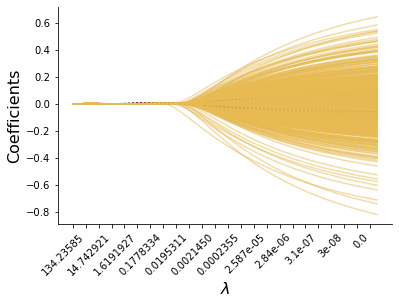

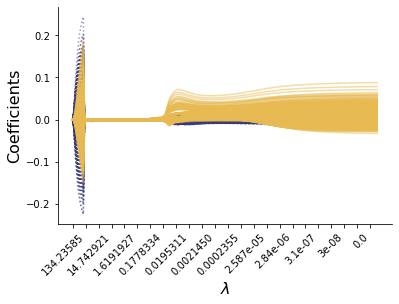

In [43]:
# Plot paths
import matplotlib
import seaborn as sns
path_plot(np.asarray(A_list)[:,:,21:22], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters,figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 

plt.locator_params(axis='x',nbins=25)


path_plot(np.asarray(Apals_list)[:,:,1:2], penalty_list, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters,figsize=(6,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 

plt.locator_params(axis='x',nbins=25)

### Generate videos

In [44]:
print('video_prefix',video_prefix)

video_prefix movies/gaussian_twoclass_centered_


#### Video of PCMF full path + X scatter plot

First figure


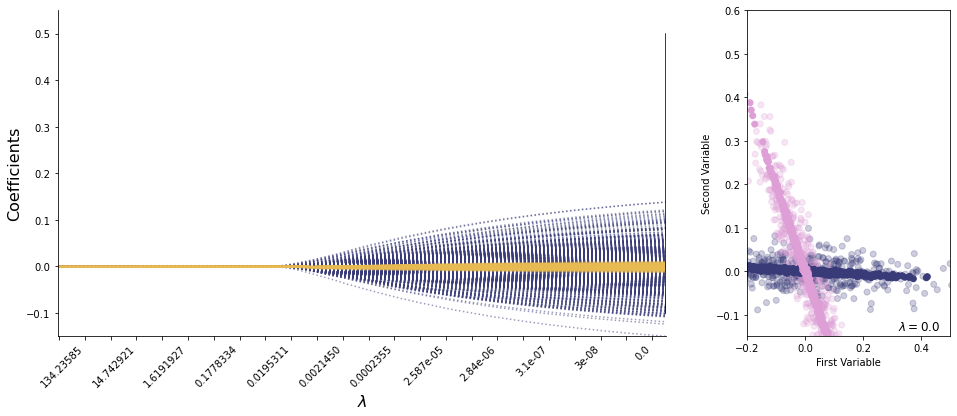

In [45]:
import seaborn as sns

# Generate video of solutions along path
print('First figure')
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib', comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)

Xhat_list = []
for i in range(len(penalty_list)):
    Xhat_list.append(np.dot(np.dot(U_list[i],np.diag(s_list[i])),V_list[i])) 

# Make videos
fig = plt.figure(figsize=(16,6))
l = plt.scatter([], [])

# plt.xlim(-0.5, 0.65)
# plt.ylim(-0.2, 0.65)

ax=fig.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

from matplotlib import gridspec
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 

with writer.saving(fig, video_prefix+"pcmf_full_"+"pathAndPlot.mp4", 300):
    for penalty_idx in range(len(penalty_list)):
        fig.clear()    
        ax = fig.add_subplot(gs[0], autoscale_on=False, xlim=(-0.6, 0.6), ylim=(-0.6, 0.6))

        path_plot_video(np.asarray(A_list)[:,:,6:7], penalty_list, penalty_idx, fig, ax, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters,figsize=(12,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
        plt.ylim(-0.15, 0.55)
        
        ax = fig.add_subplot(gs[1], autoscale_on=False, xlim=(-0.6, 0.6), ylim=(-0.6, 0.6))

        cluster_pcmf = true_clusters #cluster_pcmfs_new[penalty_idx]
        ax.scatter(X_c[:,0],X_c[:,1],c=true_clusters, alpha=0.25, cmap=scatter_cmap)

        ax.scatter(np.asarray(A_list)[penalty_idx,:,0],np.asarray(A_list)[penalty_idx,:,1], c=cluster_pcmf, cmap=scatter_cmap)
        ax.set(xlabel="First Variable")
        ax.set(ylabel="Second Variable")
        ax.text(0.95, 0.01, r"$\lambda =$"+str(np.round(penalty_list[i],5)),
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            color='black', fontsize=12)
        
        ax.set_xlim(-0.2, 0.5)
        ax.set_ylim(-0.15, 0.6)
   
        writer.grab_frame()


#### Video of PCMF PALS path + X scatter plot

First figure


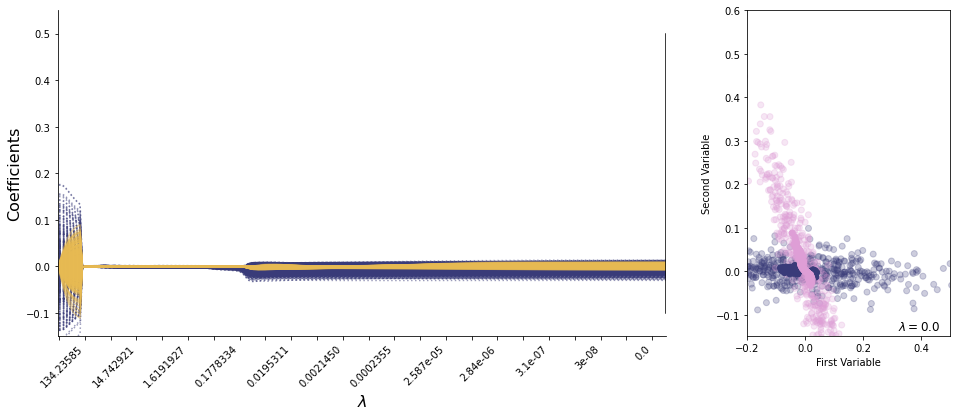

In [46]:
import seaborn as sns

# Generate video of solutions along path
print('First figure')
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib', comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)

Xhat_list = []
for i in range(len(penalty_list)):
    Xhat_list.append(np.dot(np.dot(U_list[i],np.diag(s_list[i])),V_list[i])) 

# Make videos
fig = plt.figure(figsize=(16,6))
l = plt.scatter([], [])

# plt.xlim(-0.5, 0.65)
# plt.ylim(-0.2, 0.65)

ax=fig.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

from matplotlib import gridspec
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 

with writer.saving(fig, video_prefix+"pcmf_pals_"+"pathAndPlot.mp4", 300):
    for penalty_idx in range(len(penalty_list)):
        fig.clear()    
        ax = fig.add_subplot(gs[0], autoscale_on=False, xlim=(-0.6, 0.6), ylim=(-0.6, 0.6))

        path_plot_video(np.asarray(Apals_list)[:,:,6:7], penalty_list, penalty_idx, fig, ax, plot_range=[0,len(penalty_list)],
          cut_vars=False, true_clusters=true_clusters,figsize=(12,4), 
          xticks=['134.2', '14.7' '1.6','0.2','0.02','0.002','0.0002','2.6e-5','2.5e-6','3.1e-7','3.0e-8','0.0']) 
        plt.ylim(-0.15, 0.55)
        
        ax = fig.add_subplot(gs[1], autoscale_on=False, xlim=(-0.6, 0.6), ylim=(-0.6, 0.6))

        cluster_pcmf = true_clusters # cluster_pcmfs_pals_new[penalty_idx]
        ax.scatter(X_c[:,0],X_c[:,1],c=true_clusters, alpha=0.25, cmap=scatter_cmap)

        ax.scatter(np.asarray(Apals_list)[penalty_idx,:,0],np.asarray(Apals_list)[penalty_idx,:,1], c=cluster_pcmf, cmap=scatter_cmap)
        ax.set(xlabel="First Variable")
        ax.set(ylabel="Second Variable")
        ax.text(0.95, 0.01, r"$\lambda =$"+str(np.round(penalty_list[i],5)),
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            color='black', fontsize=12)
        
        ax.set_xlim(-0.2, 0.5)
        ax.set_ylim(-0.15, 0.6)
   
        writer.grab_frame()

#### PCMF Full X scatterplot video

First figure


NameError: name 'cluster_pcmfs_new' is not defined

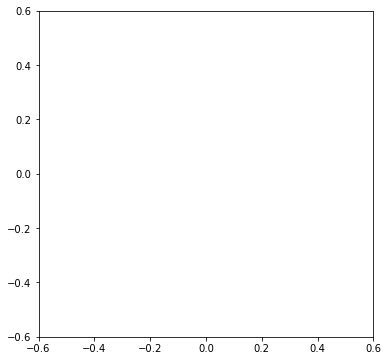

In [23]:
# Generate video of solutions along path
print('First figure')
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib', comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)

Xhat_list = []
for i in range(len(penalty_list)):
    Xhat_list.append(np.dot(np.dot(U_list[i],np.diag(s_list[i])),V_list[i])) 

# Make videos
fig = plt.figure(figsize=(6,6))
l = plt.scatter([], [])

plt.xlim(-0.5, 0.65)
plt.ylim(-0.2, 0.65)

ax=fig.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)


with writer.saving(fig, video_prefix+"pcmf_full_"+"stable_X.mp4", 300):
    for i in range(len(penalty_list)):
        fig.clear()
        ax = fig.add_subplot(111, autoscale_on=False, xlim=(-0.6, 0.6), ylim=(-0.6, 0.6))
#         cluster_pcmf = diff_graph_cluster(np.array(A_list[i]), D, comb_list, num_clusters).astype(int)
        cluster_pcmf = cluster_pcmfs_new[i]

        ax.scatter(X_c[:,0],X_c[:,1],c=true_clusters, alpha=0.25, cmap=scatter_cmap)

        ax.scatter(np.asarray(A_list)[i,:,0],np.asarray(A_list)[i,:,1], c=cluster_pcmf, cmap=scatter_cmap)
        ax.set(xlabel="First Variable")
        ax.set(ylabel="Second Variable")
        ax.text(0.95, 0.01, r"$\lambda =$"+str(np.round(penalty_list[i],5)),
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            color='black', fontsize=12)
        
        ax.set_xlim(-0.2, 0.5)
        ax.set_ylim(-0.15, 0.6)
        

        writer.grab_frame()

        

#### PCMF PALS X scatter plot video

In [ ]:
# Generate video of solutions along path
print('First figure')
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib', comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)

Xhat_list = []
for i in range(len(penalty_list)):
    Xhat_list.append(np.dot(np.dot(U_list[i],np.diag(s_list[i])),V_list[i])) 

# Make videos
fig = plt.figure(figsize=(6,6))
l = plt.scatter([], [])

plt.xlim(-0.5, 0.65)
plt.ylim(-0.2, 0.65)

ax=fig.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)


with writer.saving(fig, video_prefix+"pcmf_pals_"+"stable_X.mp4", 300):
    for i in range(len(penalty_list)):
        fig.clear()
        ax = fig.add_subplot(111, autoscale_on=False, xlim=(-0.6, 0.6), ylim=(-0.6, 0.6))

        cluster_pcmf = cluster_pcmfs_pals_new[i]

        ax.scatter(X_c[:,0],X_c[:,1],c=true_clusters, alpha=0.25, cmap=scatter_cmap)

        ax.scatter(np.asarray(Apals_list)[i,:,0],np.asarray(Apals_list)[i,:,1], c=cluster_pcmf, cmap=scatter_cmap)
        ax.set(xlabel="First Variable")
        ax.set(ylabel="Second Variable")
        ax.text(0.95, 0.01, r"$\lambda =$"+str(np.round(penalty_list[i],5)),
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            color='black', fontsize=12)
        
        ax.set_xlim(-0.2, 0.5)
        ax.set_ylim(-0.15, 0.6)
        

        writer.grab_frame()

        

#### PCMF Full and PALS X scatter plot video

First figure


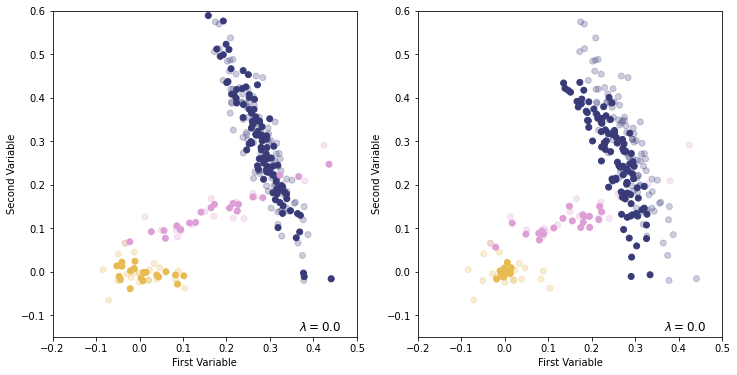

In [31]:
# Generate video of solutions along path
print('First figure')
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib', comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)

Xhat_list = []
for i in range(len(penalty_list)):
    Xhat_list.append(np.dot(np.dot(U_list[i],np.diag(s_list[i])),V_list[i])) 

# Make videos
fig = plt.figure(figsize=(12,6))
l = plt.scatter([], [])

plt.xlim(-0.5, 0.65)
plt.ylim(-0.2, 0.65)

ax=fig.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

with writer.saving(fig, video_prefix+"pcmf_full-pals_"+"stable_X.mp4", 300):
    for i in range(len(penalty_list)):
        fig.clear()
        ax = fig.add_subplot(121, autoscale_on=False, xlim=(-0.6, 0.6), ylim=(-0.6, 0.6))

        cluster_pcmf = cluster_pcmfs_new[i]

        ax.scatter(X_c[:,0],X_c[:,1],c=true_clusters, alpha=0.25, cmap=scatter_cmap)

        ax.scatter(np.asarray(A_list)[i,:,0],np.asarray(A_list)[i,:,1], c=cluster_pcmf, cmap=scatter_cmap)
        ax.set(xlabel="First Variable")
        ax.set(ylabel="Second Variable")
        ax.text(0.95, 0.01, r"$\lambda =$"+str(np.round(penalty_list[i],5)),
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            color='black', fontsize=12)
        
        ax.set_xlim(-0.2, 0.5)
        ax.set_ylim(-0.15, 0.6)
        
        ax = fig.add_subplot(122, autoscale_on=False, xlim=(-0.6, 0.6), ylim=(-0.6, 0.6))

        cluster_pcmf = cluster_pcmfs_pals_new[i]

        ax.scatter(X_c[:,0],X_c[:,1],c=true_clusters, alpha=0.25, cmap=scatter_cmap)

        ax.scatter(np.asarray(Apals_list)[i,:,0],np.asarray(Apals_list)[i,:,1], c=cluster_pcmf, cmap=scatter_cmap)
        ax.set(xlabel="First Variable")
        ax.set(ylabel="Second Variable")
        ax.text(0.95, 0.01, r"$\lambda =$"+str(np.round(penalty_list[i],5)),
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            color='black', fontsize=12)
        
        ax.set_xlim(-0.2, 0.5)
        ax.set_ylim(-0.15, 0.6)
        

        writer.grab_frame()

        